In [27]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

In [23]:
success_rate = 0.02
beta = 250
N = 5000
NN = 2000
uplift = 0.1
skew = 2.0

Find alpha for a given mean

In [ ]:
# derivation
mean = alpha / alpha + beta
alpha = mean * (alpha + beta)
alpha = mean * alpha + mean * beta
alpha - mean * alpha = mean * beta
alpha(1 - mean) = mean * beta
alpha = mean*beta/(1-mean)

# mean is a success rate in the notebook

In [61]:
alpha_0 = success_rate * beta / (1 - success_rate)
success_rate_0 = scipy.stats.beta(alpha_0, beta).rvs(NN * N).reshape(NN, N)

In [62]:
alpha_1 = success_rate * (1 + uplift) * beta / (1 - success_rate * (1 + uplift))

success_rate_1 = scipy.stats.beta(alpha_1, beta).rvs(NN * N).reshape(NN, N)

In [21]:
# rvs just generate random values?
scipy.stats.beta(alpha_1, beta).rvs(1)

array([0.01571229])

In [63]:
# to get a lognormal dist we generate normal data and take an exponent of it
views_0 = np.exp(scipy.stats.norm(1, skew).rvs(NN * N)).astype(np.int).reshape(NN, N) + 1
views_1 = np.exp(scipy.stats.norm(1, skew).rvs(NN * N)).astype(np.int).reshape(NN, N) + 1

# views are always positive, abs is fixing numerical issues with high skewness
views_0 = np.absolute(views_0)
views_1 = np.absolute(views_1)

/Users/mnefedov/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/Users/mnefedov/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If

In [65]:
# for a random success rate and a random number of view we generate random number of clicks

clicks_0 = scipy.stats.binom(n=views_0, p=success_rate_0).rvs()
clicks_1 = scipy.stats.binom(n=views_1, p=success_rate_1).rvs()


In [71]:
def generate_data(skew: float = 2.0,
                  N: int = 5000,
                  NN: int = 2000,
                  success_rate: float = 0.02,
                  uplift: float = 0.1,
                  beta: float = 250.):
    """
    Generates experimental data for N users in NN experiments
    :param skew: float, skewness of views distribution
    :param N: int, number of users in each experimental group (in control and in treatment)
    :param NN: int, number of experiments
    :param success_rate: float, mean success rate in control group
    :param uplift: float, relative uplift of mean success rate in treatment group
    :param beta: float, parameter of success rate distribution
    :return: (np.array, np.array, np.array, np.array, np.array) shape (NN, N), views in control group,
    clicks in control group, views in treatment group, clicks in treatment group, ground truth user CTRs for control group
    """
    views_0 = np.exp(scipy.stats.norm(1, skew).rvs(NN * N)).astype(int).reshape(NN, N) + 1
    views_1 = np.exp(scipy.stats.norm(1, skew).rvs(NN * N)).astype(int).reshape(NN, N) + 1

    # views are always positive, abs is fixing numerical issues with high skewness
    views_0 = np.absolute(views_0)
    views_1 = np.absolute(views_1)

    alpha_0 = success_rate * beta / (1 - success_rate)
    success_rate_0 = scipy.stats.beta(alpha_0, beta).rvs(NN * N).reshape(NN, N)

    alpha_1 = success_rate * (1 + uplift) * beta / (1 - success_rate * (1 + uplift))
    success_rate_1 = scipy.stats.beta(alpha_1, beta).rvs(NN * N).reshape(NN, N)

    clicks_0 = scipy.stats.binom(n=views_0, p=success_rate_0).rvs()
    clicks_1 = scipy.stats.binom(n=views_1, p=success_rate_1).rvs()
    return ((views_0.astype(np.float64), clicks_0.astype(np.float64)),
            (views_1.astype(np.float64), clicks_1.astype(np.float64)),
            success_rate_0.astype(np.float64))

In [146]:
success_rate = 0.02
uplift = 0.01
N = 50000
NN = 2000

beta = 100
skew = 1

ab_params = {'success_rate': success_rate, 'uplift': uplift, 'beta': beta, 'skew': skew, 'N': N, 'NN': NN}
aa_params = {'success_rate': success_rate, 'uplift': 0.0, 'beta': beta, 'skew': skew, 'N': N, 'NN': NN}

(views_0_ab, clicks_0_ab), (views_1_ab, clicks_1_ab), gt_success_rates = generate_data(**ab_params)
(views_0_aa, clicks_0_aa), (views_1_aa, clicks_1_aa), _ = generate_data(**aa_params)

In [147]:
import numpy as np
import scipy.stats
import seaborn as sns


def t_test(a, b):
    """
    Calculates two-sided t-test p-values for multiple experiments
    :param a: np.array shape (n_experiments, n_users), metric values in control group
    :param b: np.array shape (n_experiments, n_users), metric values in treatment group
    :return: np.array shape (n_experiments), two-sided p-values of t-test in all experimetns
    """
    result = list(map(lambda x: scipy.stats.ttest_ind(x[0], x[1]).pvalue, zip(a, b)))
    return np.array(result)

In [148]:
colors = sns.color_palette("deep")

In [149]:
# plt.hist(t_test(clicks_0_aa, clicks_1_aa))

In [150]:
# plt.hist(t_test(clicks_0_ab, clicks_1_ab))

In [151]:
ab_pvals = t_test(clicks_0_ab, clicks_1_ab)
aa_pvals = t_test(clicks_0_aa, clicks_1_aa)

In [152]:
def plot_cdf(data, label, ax, color, linewidth):
    sorted_data = np.sort(data)
    position = scipy.stats.rankdata(sorted_data, method='ordinal')
    cdf = position / data.shape[0]

    sorted_data = np.hstack((sorted_data, 1))
    cdf = np.hstack((cdf, 1))

    return ax.plot(sorted_data, cdf, color=color, linestyle='solid', label=label, linewidth=linewidth)


/Users/mnefedov/.pyenv/versions/3.7.2/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Ground truth user CTR, std = 0.014')

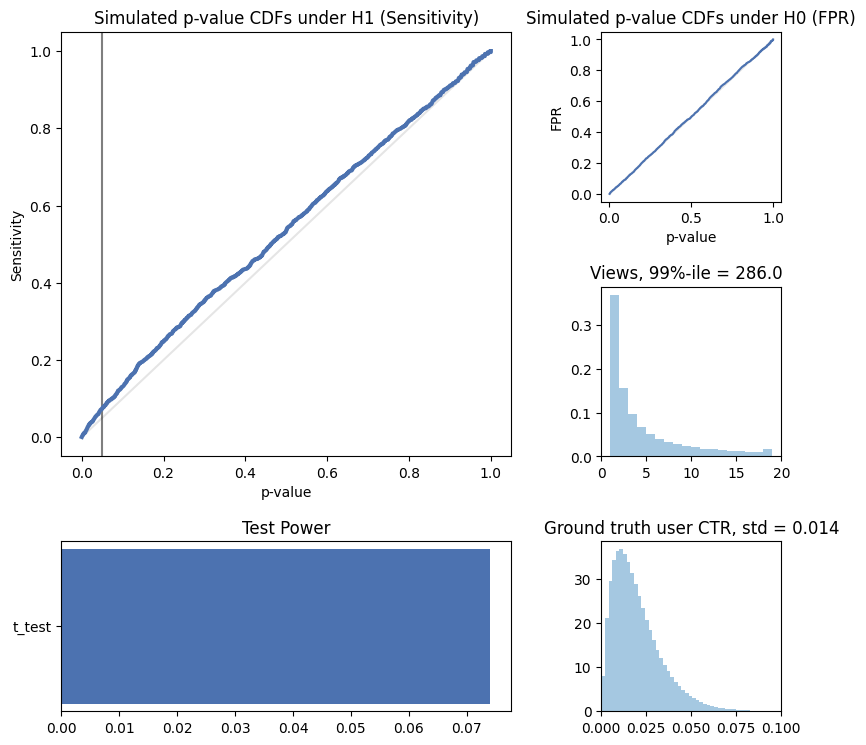

In [153]:
cdf_h1_title = 'Simulated p-value CDFs under H1 (Sensitivity)'
cdf_h0_title = 'Simulated p-value CDFs under H0 (FPR)'
fig = plt.figure(constrained_layout=False, figsize=(4 * 3, 3 * 3), dpi=100)
gs = fig.add_gridspec(3, 3)
ax_h1 = fig.add_subplot(gs[:2, :2])
ax_h0 = fig.add_subplot(gs[0, 2])


ax_views = fig.add_subplot(gs[1, 2])
ax_clicks = fig.add_subplot(gs[2, 2])
ax_powers = fig.add_subplot(gs[2, :2])

fig.subplots_adjust(left=0.3, wspace=0.5, hspace=0.5)

ax_h1.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), 'k', alpha=0.1)
ax_h0.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), 'k', alpha=0.1)

ax_h1.set_xlabel('p-value')
ax_h0.set_xlabel('p-value')
ax_h1.set_title(cdf_h1_title)
ax_h0.set_title(cdf_h0_title)

ax_h1.set_ylabel('Sensitivity')
ax_h0.set_ylabel('FPR')

ax_h1.axvline(0.05, color='k', alpha=0.5)

plot_cdf(ab_pvals, 't_test_aa', ax_h1, colors[0], linewidth=3)
plot_cdf(aa_pvals, 't_test_ab', ax_h0, colors[0], linewidth=1.5)


ax_powers.set_title('Test Power')
tests_powers = []
tests_labels = []
tests_colours = []
# for title, (ab_pvals, _, color) in dict2plot.items():
tests_labels.append('t_test')
tests_colours.append(colors[0])
tests_powers.append(np.mean(ab_pvals < 0.05))
ax_powers.barh(np.array(tests_labels), np.array(tests_powers), color=np.array(tests_colours))




sns.distplot(views_0.ravel(),
             bins=range(0, 20),
             ax=ax_views,
             kde=False,
             norm_hist=True)
ax_views.set_xlim((0, 20))
views_99_percentile = np.percentile(views_0.ravel(), 99)
ax_views.set_title(f'Views, 99%-ile = {views_99_percentile:<7.1f}')



sns.distplot(gt_success_rates.ravel(),
             bins=np.linspace(0, 0.2, 100),
             ax=ax_clicks,
             kde=False,
             norm_hist=True)
ax_clicks.set_xlim((0, 0.1))
success_rate_std = gt_success_rates[:10].flatten().std()
ax_clicks.set_title(f'Ground truth user CTR, std = {success_rate_std:2.3f}')

In [ ]:


# ax_powers.set_title('Test Power')
# tests_powers = []
# tests_labels = []
# tests_colours = []
# # for title, (ab_pvals, _, color) in dict2plot.items():
#     tests_labels.append(title)
#     tests_colours.append(color)
#     tests_powers.append(np.mean(ab_pvals < 0.05))
# ax_powers.barh(np.array(tests_labels), np.array(tests_powers), color=np.array(tests_colours))



